In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import folium
from countryinfo import CountryInfo
import requests
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
plt.rc('font', size=12)

/Users/vayner/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Ceny kokainy w latach 2016-2019

wczytywanie danych

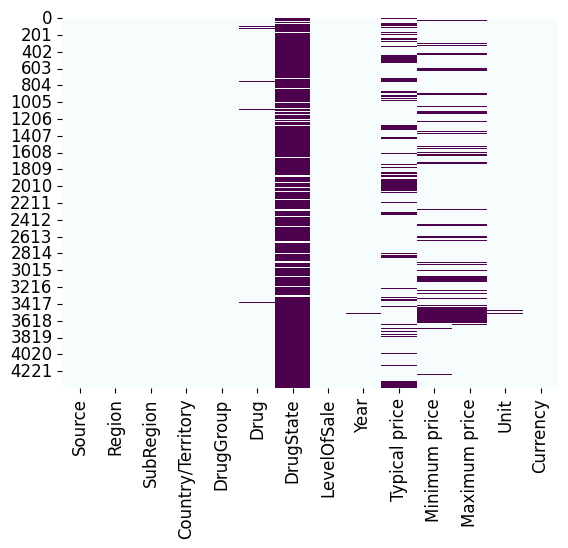

In [2]:
prices = pd.read_csv("datasets/prices.csv", delimiter=",", decimal=",")

prices = prices.replace("Türkiye", "Turkey")
prices = prices.replace("Iran (Islamic Republic of)", "Iran")
prices = prices.replace("Bolivia (Plurinational State of)", "Bolivia")
prices = prices.replace("United Kingdom of Great Britain and Northern Ireland", "United Kingdom")
prices = prices.replace("Bahamas", "The Bahamas")
prices = prices.replace("Venezuela (Bolivarian Republic of)", "Venezuela")
prices = prices.replace("Russian Federation", "Russia")
prices = prices.replace("Côte d'Ivoire", "Ivory Coast")
prices = prices.replace("Lao People's Democratic Republic", "Laos")
prices = prices.replace("Republic of Korea", "South Korea")
prices = prices.replace("Viet Nam", "Vietnam")
prices = prices.replace("Serbia", "Republic of Serbia")
prices = prices.replace("Republic of Moldova", "Moldova")
prices = prices.replace("Syrian Arab Republic", "Syria")
prices = prices.replace("China, Macao SAR", "China")
prices = prices.replace("China, Hong Kong SAR", "Hong Kong")
prices = prices.replace("China, Taiwan Province of China", "Taiwan")
prices = prices.replace("Timor-Leste", "East Timor")
prices = prices.replace("North Macedonia", "Macedonia")
prices = prices.replace("Czechia", "Czech Republic")
prices = prices.replace("State of Palestine", "Israel") # giga sadeg

sns.heatmap(prices.isnull(), cmap='BuPu', cbar=False)
plt.rc('font', size=12)

sprowadzenie wszyskich cen do dolara i wagi do 1 grama.

In [3]:
prices = prices.drop(prices[(prices['Drug'] != 'Cocaine')].index)
prices = prices.drop(prices[(prices['Unit'] == 'Rock') | (prices['Unit'] == 'Dose')| (prices['Unit'] == 'Unit')
                            | (prices['Unit'] == 'Tablet') | (prices['Unit'] == 'Capsule') | (prices['Unit'] == 'Millilitre')].index)
prices = prices.drop_duplicates(subset=['Country/Territory', 'Year', 'LevelOfSale'], keep='first')

prices = prices[prices['Typical price'].notnull()]

prices['Typical price'] = pd.to_numeric(prices['Typical price'], errors='coerce')
prices['Maximum price'] = pd.to_numeric(prices['Maximum price'], errors='coerce')
prices['Minimum price'] = pd.to_numeric(prices['Minimum price'], errors='coerce')

def get_currency(row):
    country_name = row['Country/Territory']
    current_currency = row['Currency']

    if current_currency == 'Euro' or current_currency == 'EUR':
        return 'EUR'
    elif current_currency == 'United States dollar' or current_currency == 'USA':
        return 'USD'
    elif current_currency == 'CHF':
        return 'CHF'
    else:
        return get_currency_code(country_name)

def get_currency_code(country_name):
    try:
        country_info = CountryInfo(country_name)
        currency_code = country_info.currencies()[0]
        return currency_code
    except KeyError:
        if country_name == 'Montenegro' or country_name == 'Macedonia':
            return 'EUR'
        return None


prices['CountryCode'] = prices.apply(get_currency, axis=1)
prices['CountryCode'] = prices['CountryCode'].replace('ZMK','ZMW')
prices['CountryCode'] = prices['CountryCode'].replace('CLF','CLP')
prices['CountryCode'] = prices['CountryCode'].replace('UYI','UYU')

def kurs_wzgledem_dolara(df):
    key = '81762adf326fc352149a4719e3075c98'
    url = f"http://api.exchangeratesapi.io/latest?access_key={key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        kursy = data["rates"]
        kursy['USD'] = 1
        df['exchangeRate'] = df['CountryCode'].map(kursy)
    else:
        print("Błąd podczas pobierania danych kursów walut")

def weight_ratio(row):
    unit = row['Unit']

    if unit == 'Kilogram':
        return 0.001
    elif unit == 'Gram':
        return 1
    elif unit == 'Ounce':
        return 0.03527
    elif unit == '250 milligram':
        return 4
    elif unit == '200 milligram':
        return 5
    elif unit == '10 gram':
        return 0.1
    else:
        return 0

kurs_wzgledem_dolara(prices)

prices['Typical price'] = prices['Typical price'] / (prices['exchangeRate'])
prices['Minimum price'] = prices['Minimum price'] / (prices['exchangeRate'])
prices['Maximum price'] = prices['Maximum price'] / (prices['exchangeRate'])

prices['Weight ratio'] = prices.apply(weight_ratio, axis=1)
prices['Price of gram'] = prices['Typical price'] * prices['Weight ratio']

pricesWholesale = prices[prices['LevelOfSale'] == 'Wholesale']
pricesStreets = prices[prices['LevelOfSale'] == 'Street']

/var/folders/53/mk2f0x450cs16rt_s6h4bj1m0000gn/T/ipykernel_24688/33701501.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)


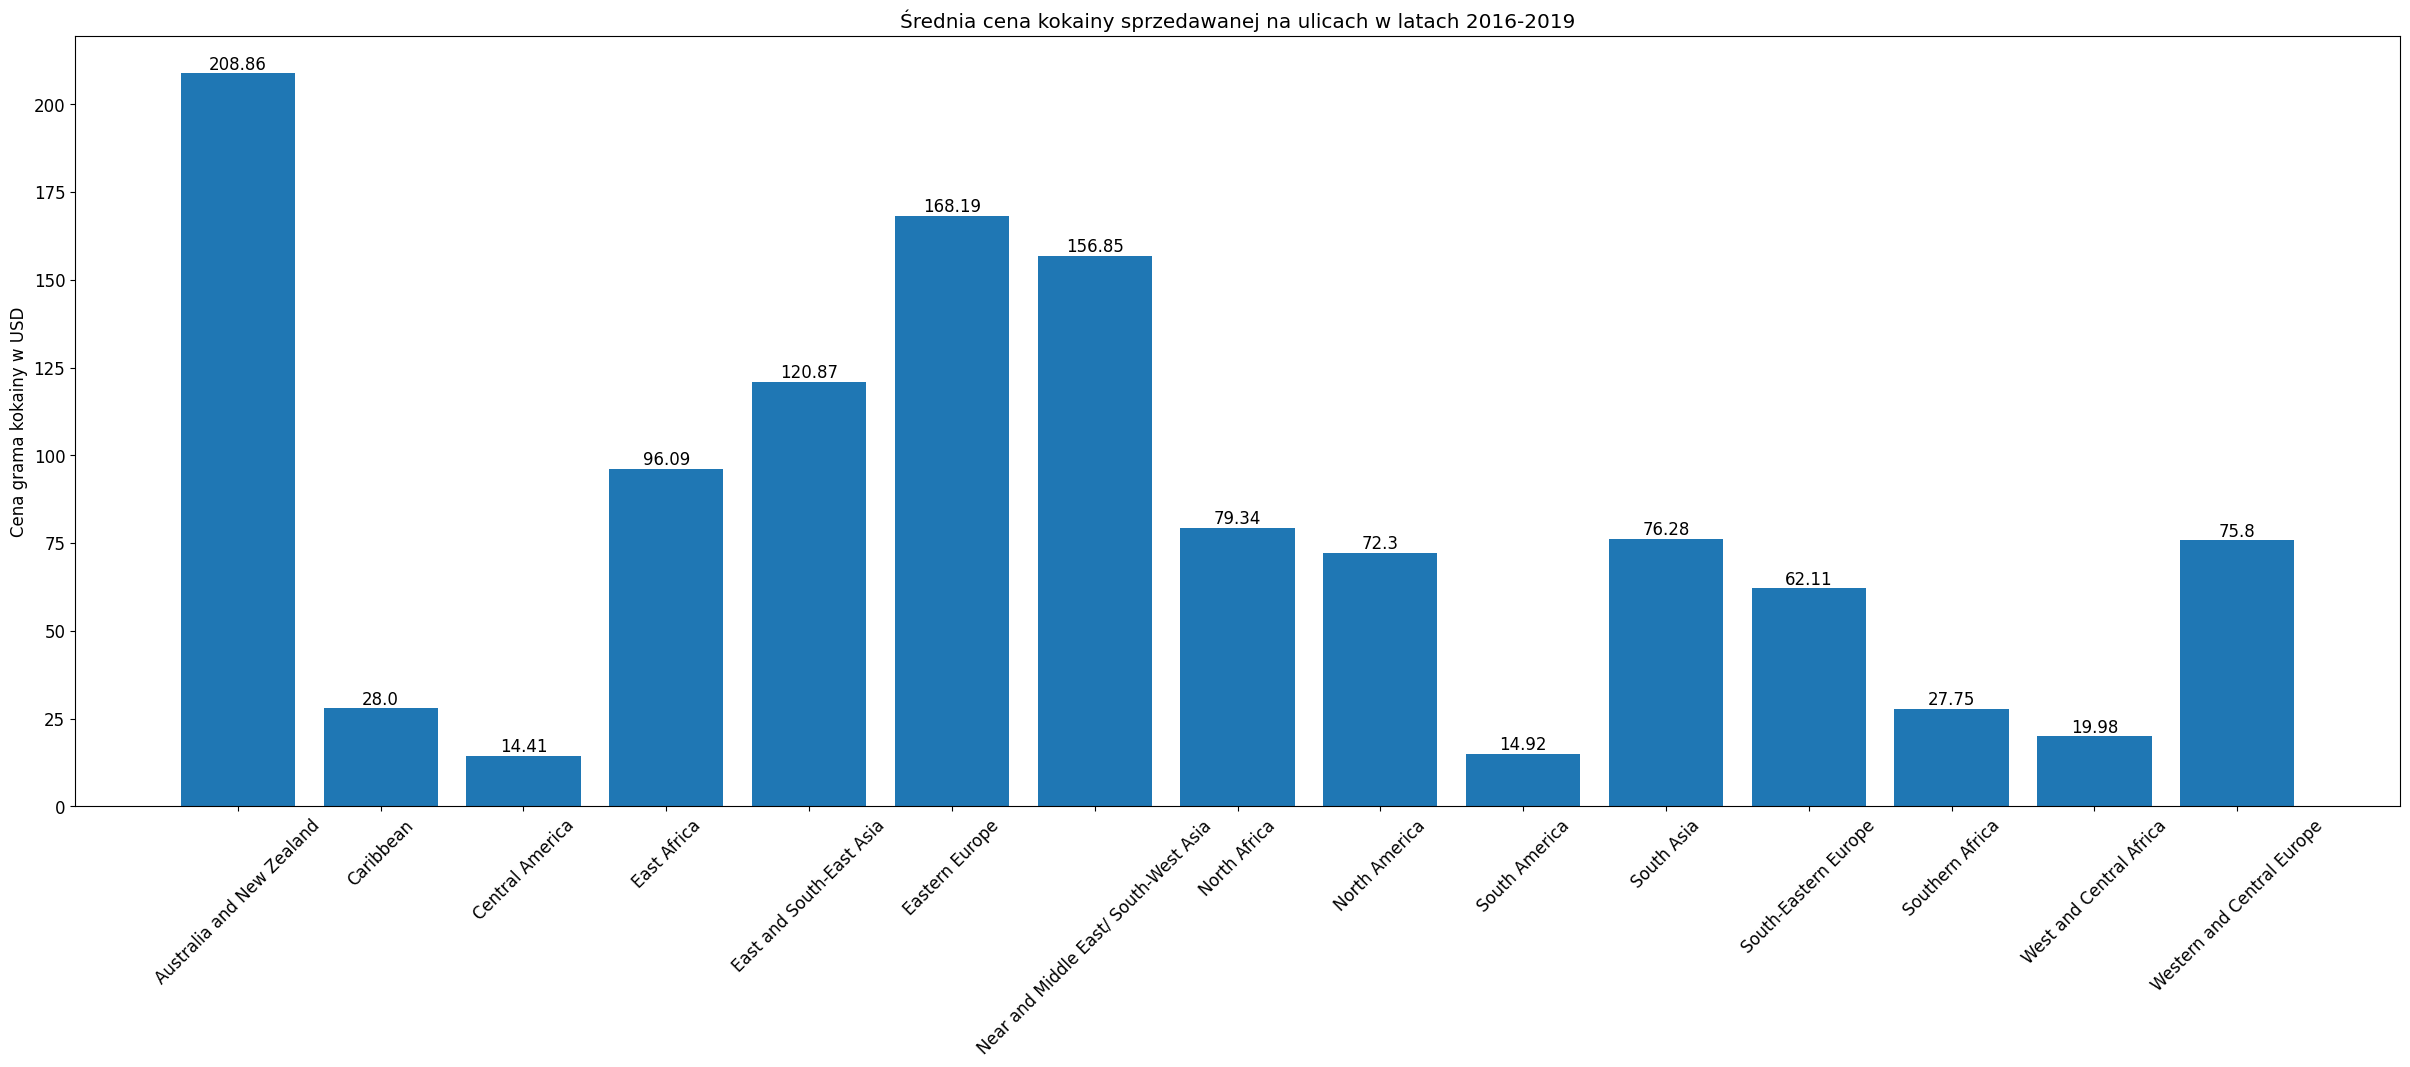

In [4]:
subRegionStreet = pricesStreets.groupby('SubRegion')['Price of gram'].mean().reset_index()

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(subRegionStreet['SubRegion'], subRegionStreet['Price of gram'])

# Dodawanie liczb na słupkach
for i, bar in enumerate(bars):
    height = bar.get_height()
    value = round(subRegionStreet['Price of gram'][i], 2)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            value,
            ha='center', va='bottom')

ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)
ax.set_ylabel('Cena grama kokainy w USD')
ax.set_title('Średnia cena kokainy sprzedawanej na ulicach w latach 2016-2019')

# Wyświetlanie wykresu
plt.show()

/var/folders/53/mk2f0x450cs16rt_s6h4bj1m0000gn/T/ipykernel_24688/1328698383.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)


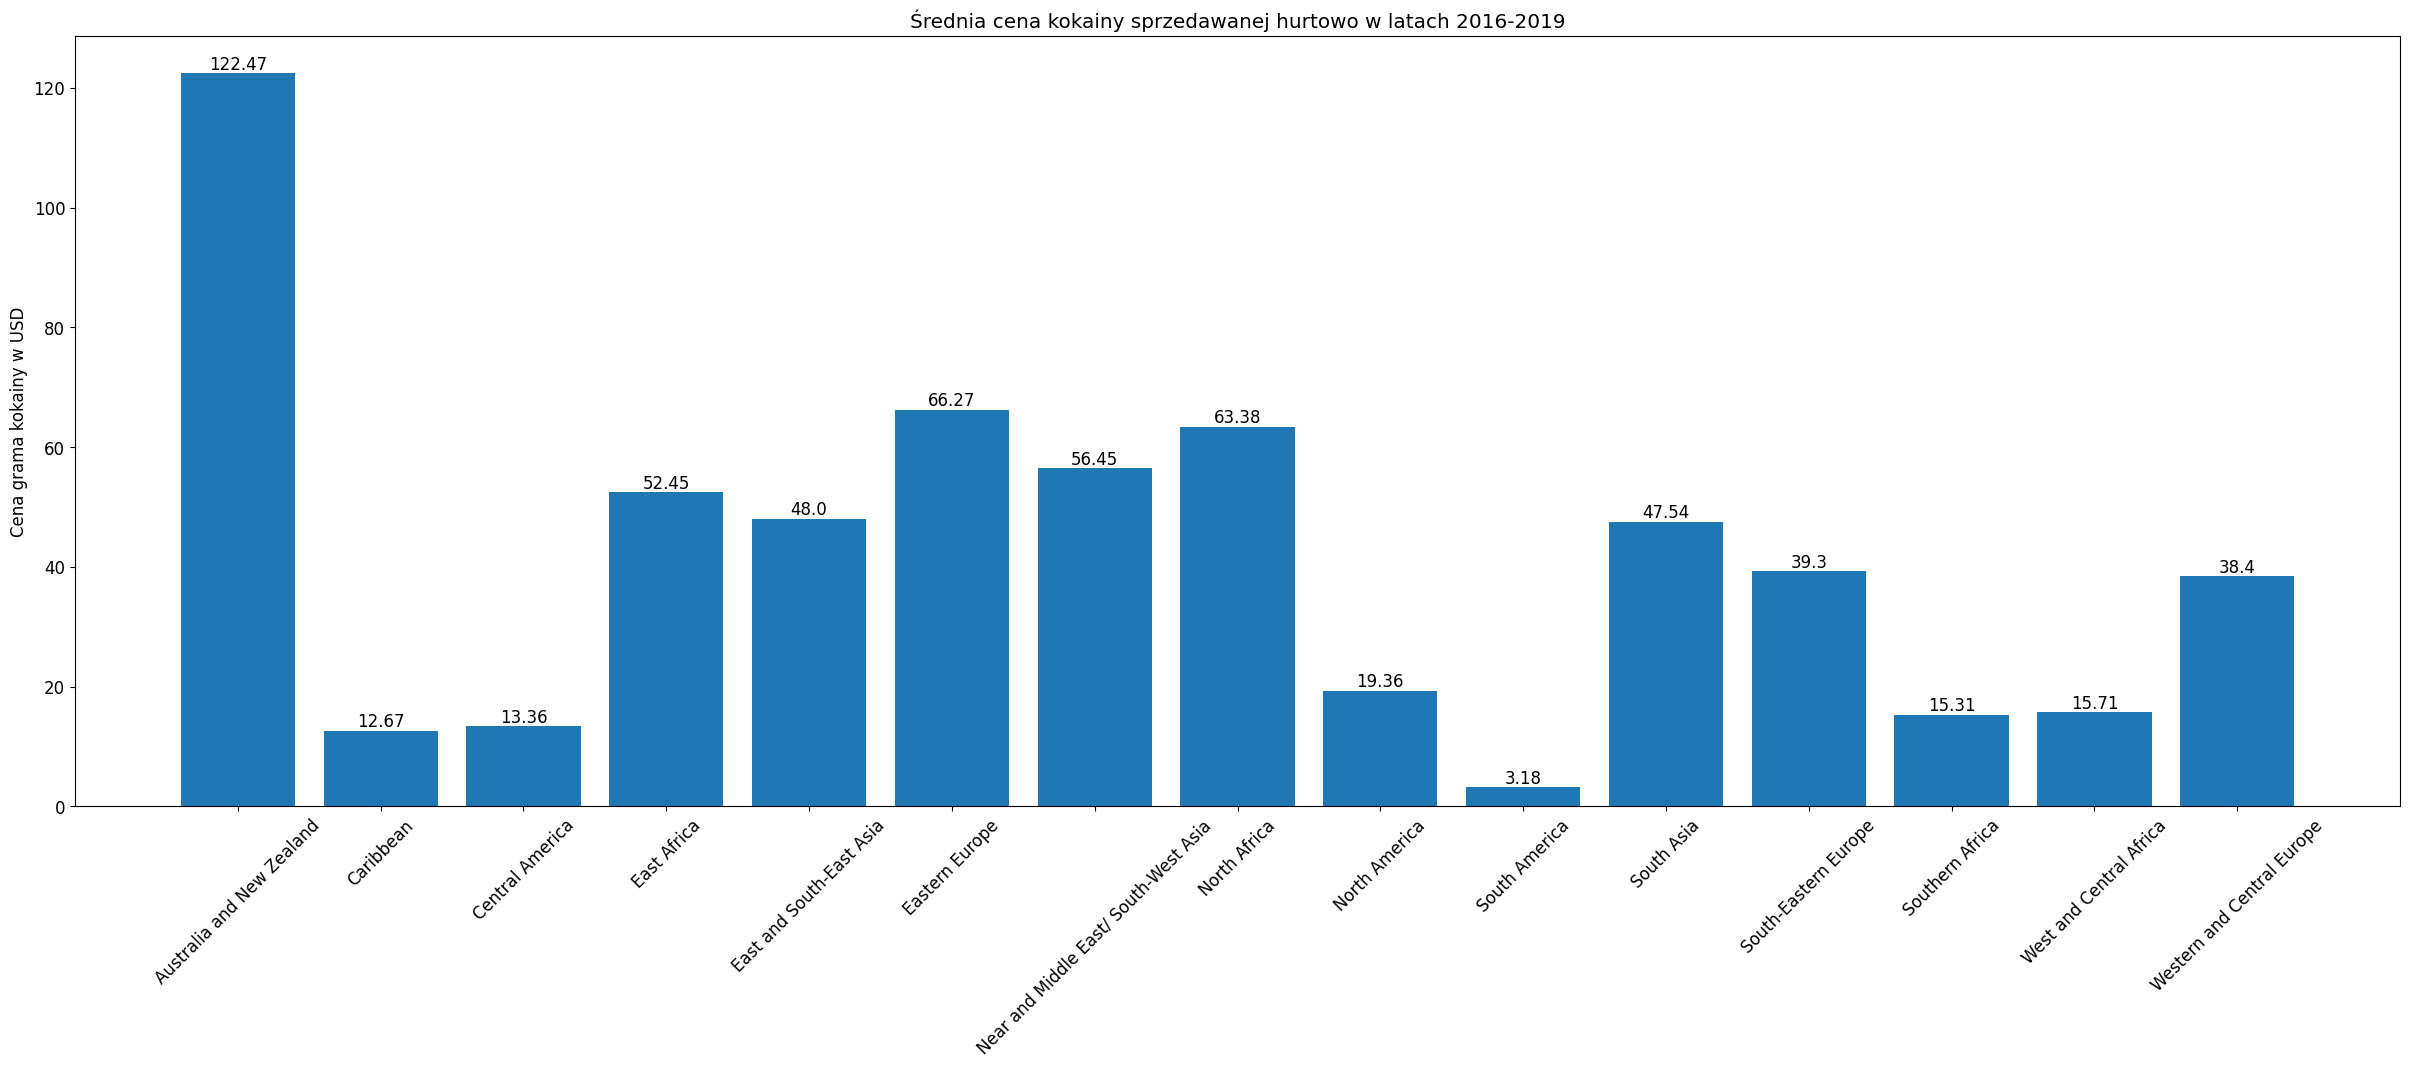

In [5]:
subRegionWholesale = pricesWholesale.groupby('SubRegion')['Price of gram'].mean().reset_index()

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(subRegionWholesale['SubRegion'], subRegionWholesale['Price of gram'])

# Dodawanie liczb na słupkach
for i, bar in enumerate(bars):
    height = bar.get_height()
    value = round(subRegionWholesale['Price of gram'][i], 2)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            value,
            ha='center', va='bottom')
ax.set_ylabel('Cena grama kokainy w USD')
ax.set_title('Średnia cena kokainy sprzedawanej hurtowo w latach 2016-2019')
ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)

# Wyświetlanie wykresu
plt.show()

/var/folders/53/mk2f0x450cs16rt_s6h4bj1m0000gn/T/ipykernel_24688/2546742035.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)


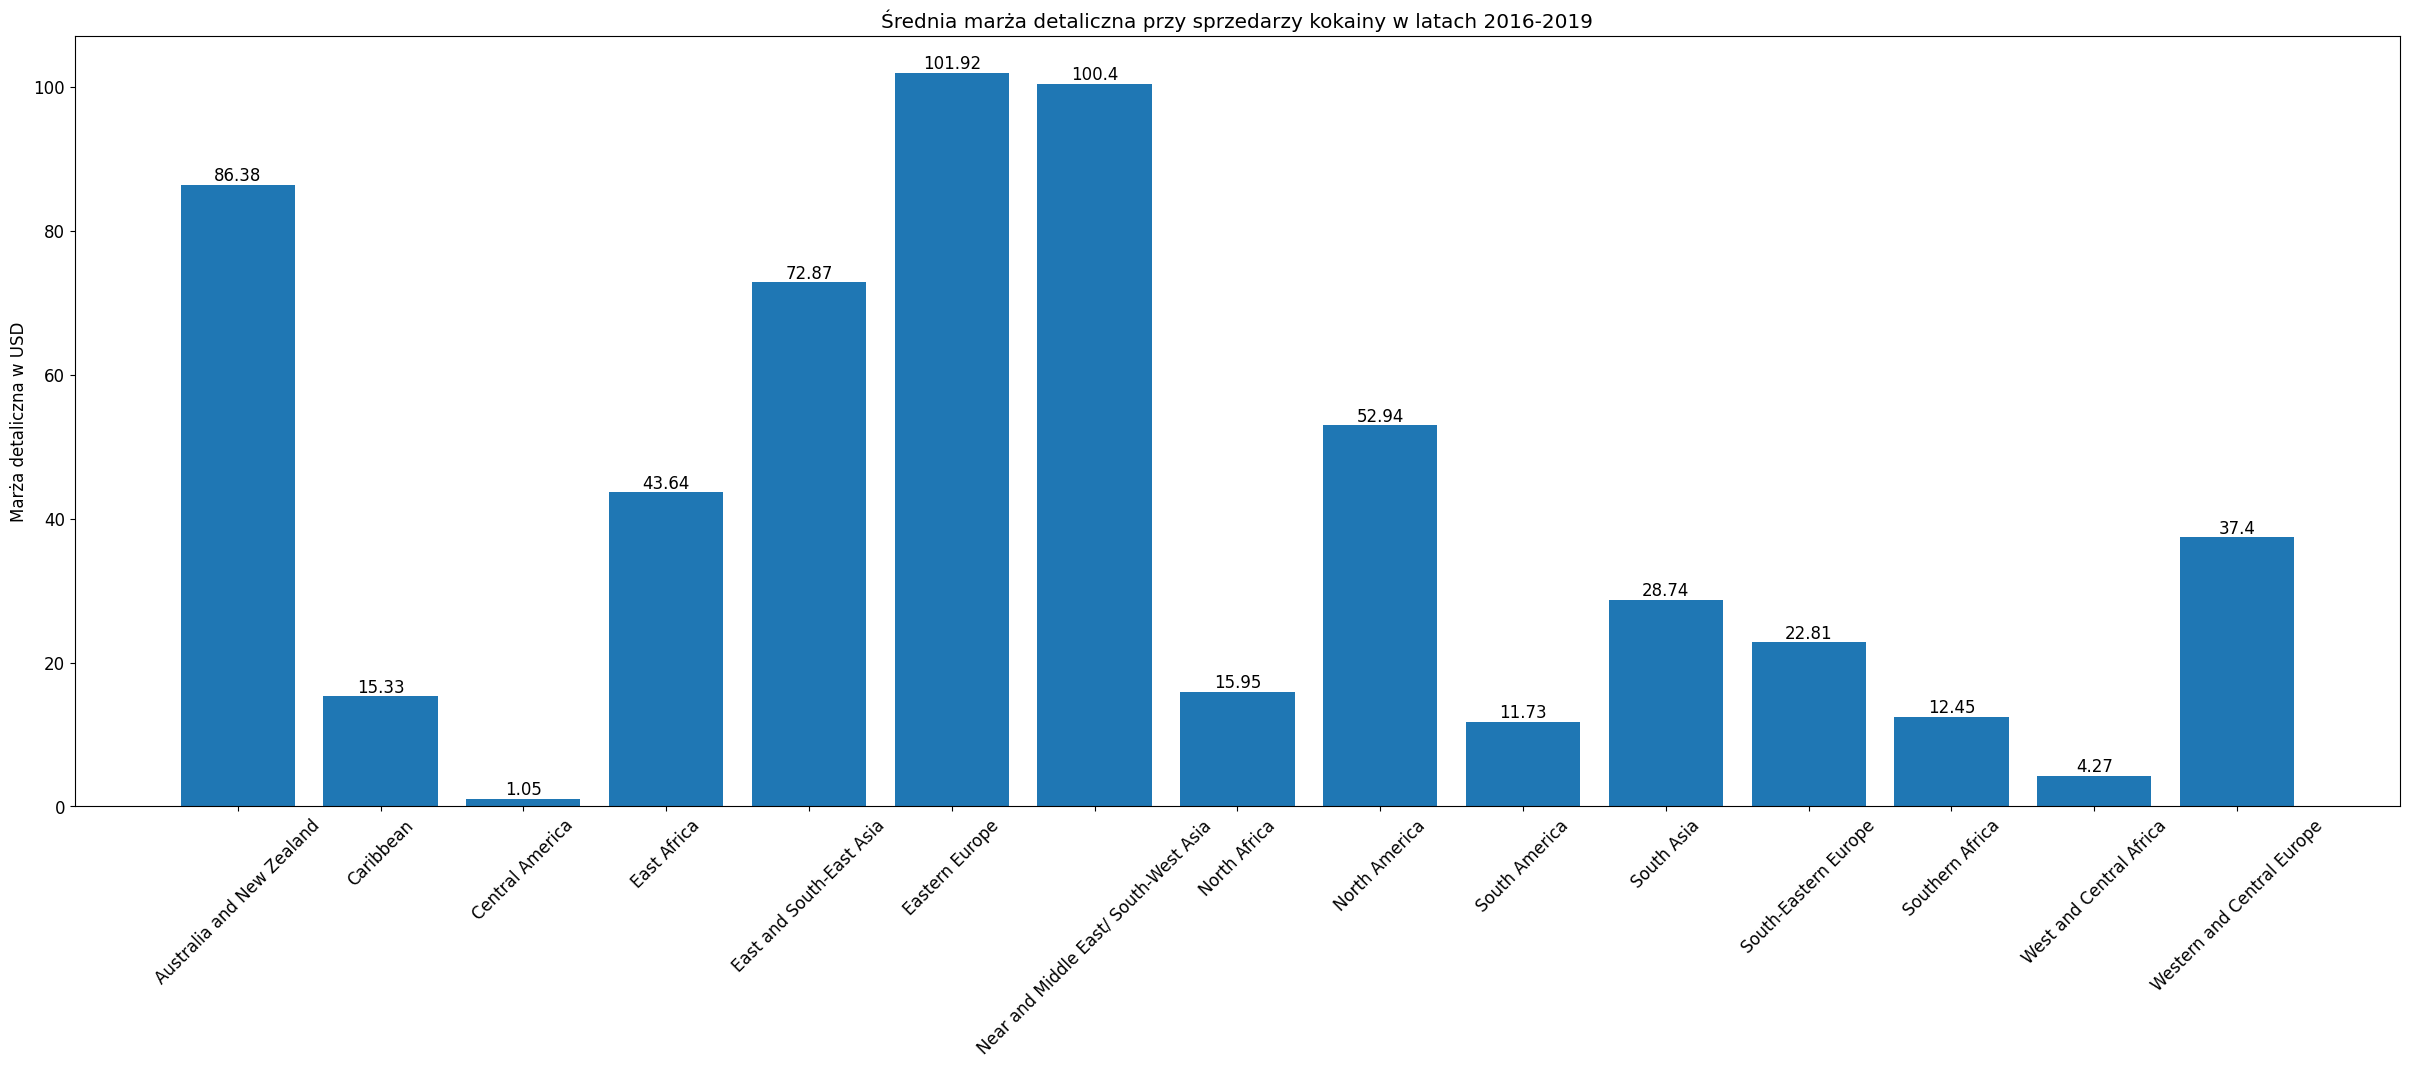

In [6]:
subRegionStreet = subRegionStreet.rename(columns={'Price of gram': 'detal'})
subRegionWholesale = subRegionWholesale.rename(columns={'Price of gram': 'hurt'})

subregionDifference = pd.merge(subRegionWholesale, subRegionStreet, on='SubRegion', how='inner')

subregionDifference['margin'] = subregionDifference['detal'] - subregionDifference['hurt']

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(subregionDifference['SubRegion'], subregionDifference['margin'])

# Dodawanie liczb na słupkach
for i, bar in enumerate(bars):
    height = bar.get_height()
    value = round(subregionDifference['margin'][i], 2)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            value,
            ha='center', va='bottom')

ax.set_ylabel('Marża detaliczna w USD')
ax.set_title('Średnia marża detaliczna przy sprzedarzy kokainy w latach 2016-2019')
ax.set_xticklabels(subRegionStreet['SubRegion'], rotation=45)

# Wyświetlanie wykresu
plt.show()

/var/folders/53/mk2f0x450cs16rt_s6h4bj1m0000gn/T/ipykernel_24688/3533374267.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pricesStreetsEurope['Country/Territory'], rotation=45)


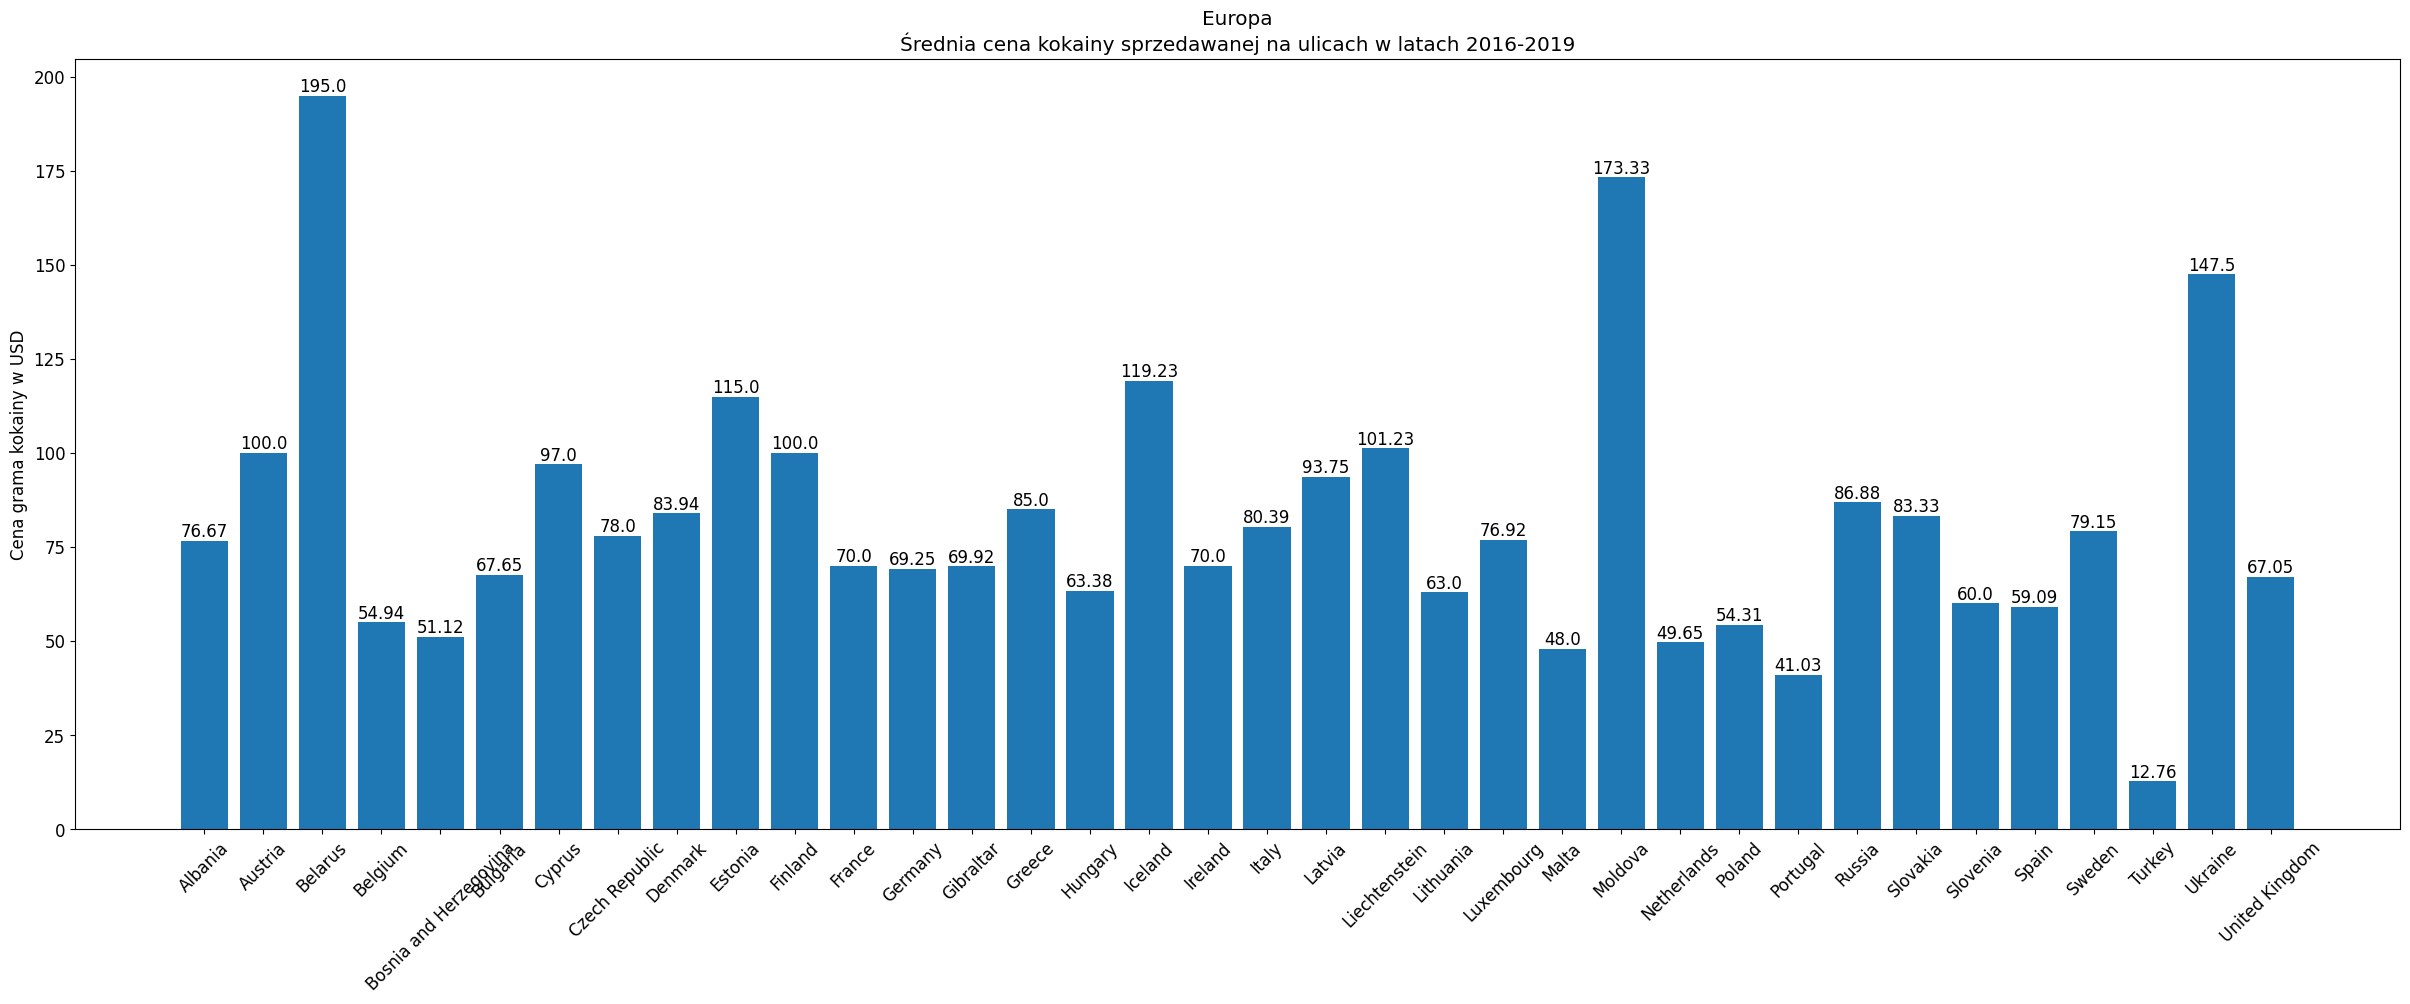

In [7]:
pricesStreetsEurope = pricesStreets[pricesStreets['Region'] == 'Europe']
pricesStreetsEurope = pricesStreetsEurope.groupby("Country/Territory")['Price of gram'].mean().reset_index()

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(pricesStreetsEurope['Country/Territory'], pricesStreetsEurope['Price of gram'])

# Dodawanie liczb na słupkach
for i, bar in enumerate(bars):
    height = bar.get_height()
    value = round(pricesStreetsEurope['Price of gram'][i], 2)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            value,
            ha='center', va='bottom')

ax.set_ylabel('Cena grama kokainy w USD')
ax.set_title('Europa\nŚrednia cena kokainy sprzedawanej na ulicach w latach 2016-2019')
ax.set_xticklabels(pricesStreetsEurope['Country/Territory'], rotation=45)

# Wyświetlanie wykresu
plt.show()

/var/folders/53/mk2f0x450cs16rt_s6h4bj1m0000gn/T/ipykernel_24688/2983523594.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(europeDifference['Country/Territory'], rotation=45)


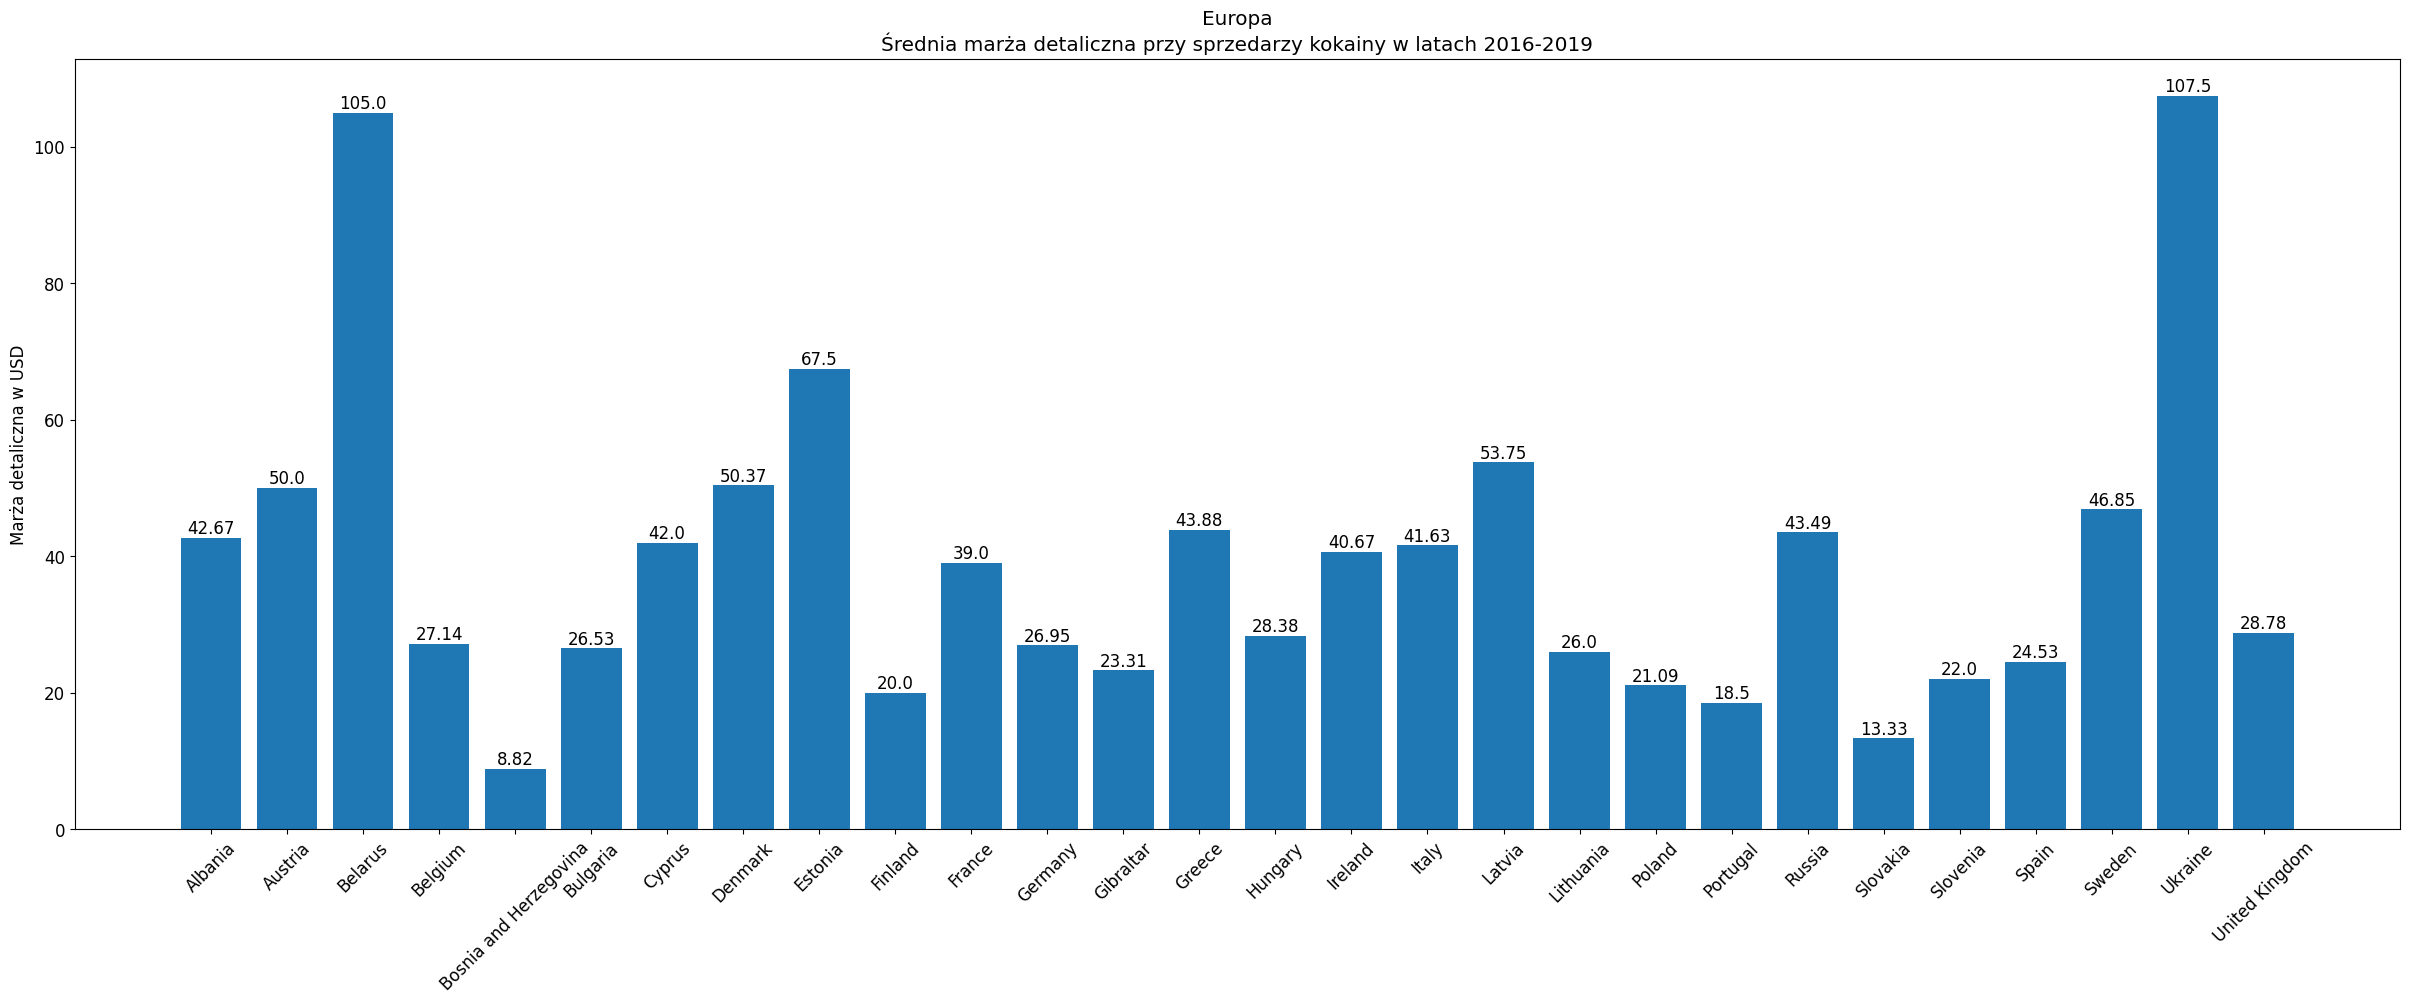

In [8]:
pricesWholesaleEurope = pricesWholesale[pricesWholesale['Region'] == 'Europe']
pricesWholesaleEurope = pricesWholesaleEurope.groupby("Country/Territory")['Price of gram'].mean().reset_index()


pricesStreetsEurope = pricesStreetsEurope.rename(columns={'Price of gram': 'detal'})
pricesWholesaleEurope = pricesWholesaleEurope.rename(columns={'Price of gram': 'hurt'})

europeDifference = pd.merge(pricesWholesaleEurope, pricesStreetsEurope, on='Country/Territory', how='inner')

europeDifference['margin'] = europeDifference['detal'] - europeDifference['hurt']

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(europeDifference['Country/Territory'], europeDifference['margin'])

# Dodawanie liczb na słupkach
for i, bar in enumerate(bars):
    height = bar.get_height()
    value = round(europeDifference['margin'][i], 2)
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            value,
            ha='center', va='bottom')

ax.set_ylabel('Marża detaliczna w USD')
ax.set_title('Europa\nŚrednia marża detaliczna przy sprzedarzy kokainy w latach 2016-2019')
ax.set_xticklabels(europeDifference['Country/Territory'], rotation=45)

# Wyświetlanie wykresu
plt.show()

In [9]:
averageStreets = pricesStreets.groupby('Country/Territory')['Price of gram'].mean().reset_index()
averageWholesale = pricesWholesale.groupby('Country/Territory')['Price of gram'].mean().reset_index()

def mapka(df, legend):
    map = folium.Map(height=700 ,location=[50, 10], zoom_start=4)
    df_world = geopandas.read_file("datasets/110m_cultural.zip").merge(
        df,
        how='right',
        left_on=['ADMIN'],
        right_on=['Country/Territory']
    )
    folium.Choropleth(
        geo_data=df_world,
        data=df_world,
        columns=['Country/Territory', 'Price of gram'],
        key_on="feature.properties.Country/Territory",
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend
    ).add_to(map)

    return map

mapka(averageStreets, "Średnia cena kokainy na ulicach w latach 2016-2019 w USD")

In [10]:
mapka(averageWholesale, "Średnia cena kokainy hurt w latach 2016-2019 w USD")